In [11]:
import torch

print(torch.cuda.is_available())


print(torch.cuda.device_count())


print(torch.cuda.current_device())


print(torch.cuda.device(0))


print(torch.cuda.get_device_name(0))




True
1
0
NVIDIA GeForce RTX 3060 Laptop GPU


In [12]:
import os
import time
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import Tensor
from torch import nn


In [13]:
class GoogLeNet(nn.Module):
    def __init__(self, aux_logits=True, num_classes=1):
        super(GoogLeNet, self).__init__()
        assert aux_logits == True or aux_logits == False
        self.aux_logits = aux_logits


        self.conv1 = conv_block(in_channels = 3, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)

        self.inception5a = Inception_block(832,256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832,384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)
        


        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        else:
            self.aux1 = self.aux2 = None

    def forward(self,x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x= self.conv2(x)
        x= self.maxpool2(x)


        x = self.inception3a(x)    
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)

        
        # Auxiliary Softmax classifier 1
        
        if self.aux_logits and self.training:
            aux1 = self.aux1(x)




        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        if self.aux_logits and self.training:
            aux2 = self.aux2(x)



        x = self.inception4e(x)
        x = self.maxpool4(x)


        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        
      
        if self.aux_logits and self.training:
            return aux1, aux2, x
        else:
            return x





class Inception_block(nn.Module):
    def __init__ (self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(conv_block(in_channels, red_3x3, kernel_size=1), conv_block(red_3x3, out_3x3, kernel_size=3, padding=1 ))
        self.branch3 = nn.Sequential(conv_block(in_channels, red_5x5, kernel_size=1), conv_block(red_5x5, out_5x5, kernel_size =5, padding=2))
        self.branch4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1), conv_block(in_channels, out_1x1pool, kernel_size=1))

    def forward(self,x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)
    
    
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.7)
        self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = conv_block(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    






class conv_block(nn.Module): 
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self,x):
        return self.relu(self.batchnorm(self.conv(x)))

In [14]:

if __name__ == "__main__":
    BATCH_SIZE = 5
    x = torch.randn(BATCH_SIZE, 3, 224, 224)
    model = GoogLeNet(aux_logits=True, num_classes=1)
    print(model(x)[2].shape)
    assert model(x)[2].shape == torch.Size([BATCH_SIZE, 1])

torch.Size([5, 1])


In [24]:
import os
import torch
from torchvision import datasets, transforms
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2

transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

# Load the dataset with the custom transform
dataset = datasets.ImageFolder(root='C:/Users/cnaja/IISC/NJN/data/', transform= transforms)


# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - (train_size + val_size)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size= 32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size= 32, shuffle=False)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

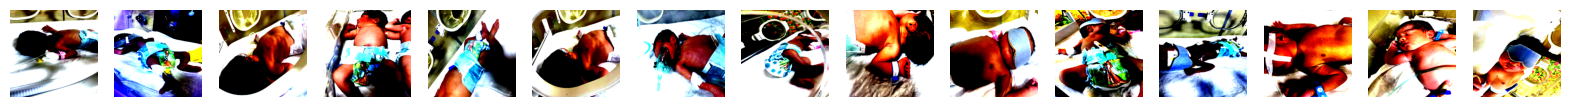

In [25]:
import matplotlib.pyplot as plt

# Function to show a batch of images
def show_images(images, nmax=15):
    fig, axes = plt.subplots(nrows=1, ncols=min(nmax, len(images)), figsize=(20, 3))
    for i, ax in enumerate(axes):
        image = images[i].permute(1, 2, 0)  
        ax.imshow(image)
        ax.axis('off')
    plt.show()

# Get a single batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Since the transforms are already applied in the DataLoader, just visualize them
show_images(images)




In [26]:
from torch.optim import lr_scheduler
from torch import nn, optim
import torch.optim as optim
import torch
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torch.nn.utils import clip_grad_norm_

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.constant_(m.weight, 1)
        torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        torch.nn.init.constant_(m.bias, 0)





# Initialize the metrics
task = 'binary'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accuracy = Accuracy(task=task).to(device)
precision = Precision(task=task, num_classes=2, average='macro').to(device)
recall = Recall(task=task, num_classes=2, average='macro').to(device)
f1_score = F1Score(task=task, num_classes=2, average='macro').to(device)

# Initialize the model, criterion, and optimizer
# Apply the initialization
model = GoogLeNet(aux_logits=True, num_classes=1)
model.apply(initialize_weights)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)


# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


early_stopping_patience = 20
min_val_loss = float('inf')
patience_counter = 0

def reset_metrics():
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1_score.reset()

def update_metrics(preds, labels):
    preds = torch.sigmoid(preds) >= 0.5
    accuracy(preds, labels.int())
    precision(preds, labels.int())
    recall(preds, labels.int())
    f1_score(preds, labels.int())



def print_metrics(epoch, phase="Validation"):
    print(f"{phase} Metrics Epoch {epoch+1}: Accuracy: {accuracy.compute():.4f}, Precision: {precision.compute():.4f}, Recall: {recall.compute():.4f}, F1 Score: {f1_score.compute():.4f}")


train_acc, train_prec, train_recall, train_f1 = [], [], [], []
val_acc, val_prec, val_recall, val_f1 = [], [], [], []

    
def train(epoch):
    model.train()
    running_loss = 0.0
    reset_metrics()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Handle outputs when auxiliary classifiers are used
        if isinstance(outputs, tuple):
            loss_main = criterion(outputs[2], labels)
            loss_aux1 = criterion(outputs[0], labels)
            loss_aux2 = criterion(outputs[1], labels)
            loss = loss_main + 0.4 * loss_aux1 + 0.4 * loss_aux2  
        else:
            loss = criterion(outputs, labels)
        
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        running_loss += loss.item()
        
       s
        update_metrics(outputs[2] if isinstance(outputs, tuple) else outputs, labels)
        
    epoch_loss = running_loss / len(train_loader)
    
  
    train_acc.append(accuracy.compute().item())
    train_prec.append(precision.compute().item())
    train_recall.append(recall.compute().item())
    train_f1.append(f1_score.compute().item())
    
    
    reset_metrics()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")
    print(f"Training Metrics Epoch {epoch+1}: Accuracy: {train_acc[-1]:.4f}, Precision: {train_prec[-1]:.4f}, Recall: {train_recall[-1]:.4f}, F1 Score: {train_f1[-1]:.4f}")

def validate(epoch):
    global min_val_loss, patience_counter
    model.eval()
    val_loss = 0.0
    reset_metrics()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(inputs)
            
            # Handle outputs when auxiliary classifiers are used
            if isinstance(outputs, tuple):
                loss_main = criterion(outputs[2], labels)
                loss_aux1 = criterion(outputs[0], labels)
                loss_aux2 = criterion(outputs[1], labels)
                loss = loss_main + 0.4 * loss_aux1 + 0.4 * loss_aux2  
            else:
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            # Use main output for metrics
            update_metrics(outputs[2] if isinstance(outputs, tuple) else outputs, labels)
    
    # Compute average validation loss for the epoch
    epoch_val_loss = val_loss / len(val_loader)
    
    # Retrieve and append the averaged metrics for the entire epoch
    val_acc.append(accuracy.compute().item())
    val_prec.append(precision.compute().item())
    val_recall.append(recall.compute().item())
    val_f1.append(f1_score.compute().item())
    
    # Reset metrics for the next epoch
    reset_metrics()

    print(f"Epoch {epoch+1}, Validation Loss: {epoch_val_loss}")
    print(f"Validation Metrics Epoch {epoch+1}: Accuracy: {val_acc[-1]:.4f}, Precision: {val_prec[-1]:.4f}, Recall: {val_recall[-1]:.4f}, F1 Score: {val_f1[-1]:.4f}")

    #scheduler.step(epoch_val_loss)
    
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Validation loss decreased to {min_val_loss:.6f}. Saving the model!")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            return True
    return False




best_model_path = 'Gnet_NJN4.pth'
num_epochs = 500  

for epoch in range(num_epochs):
    train(epoch)
    stop_training = validate(epoch)
    if stop_training:
        print("Stopping training...")
        break
    scheduler.step() 


model.load_state_dict(torch.load(best_model_path))
model.eval()


Epoch 1, Loss: 30.10133866702809
Training Metrics Epoch 1: Accuracy: 0.7218, Precision: 0.2727, Recall: 0.0435, F1 Score: 0.0750
Epoch 1, Validation Loss: 14.867309808731079
Validation Metrics Epoch 1: Accuracy: 0.7632, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Validation loss decreased to 14.867310. Saving the model!
Epoch 2, Loss: 19.94521163491642
Training Metrics Epoch 2: Accuracy: 0.7594, Precision: 0.5833, Recall: 0.2536, F1 Score: 0.3535
Epoch 2, Validation Loss: 12.000304937362671
Validation Metrics Epoch 2: Accuracy: 0.7807, Precision: 1.0000, Recall: 0.0741, F1 Score: 0.1379
Validation loss decreased to 12.000305. Saving the model!
Epoch 3, Loss: 14.789470336016487
Training Metrics Epoch 3: Accuracy: 0.7970, Precision: 0.6744, Recall: 0.4203, F1 Score: 0.5179
Epoch 3, Validation Loss: 10.9862699508667
Validation Metrics Epoch 3: Accuracy: 0.7632, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Validation loss decreased to 10.986270. Saving the model!
Epoch 4, Lo

GoogLeNet(
  (conv1): conv_block(
    (relu): ReLU()
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): conv_block(
    (relu): ReLU()
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): Inception_block(
    (branch1): conv_block(
      (relu): ReLU()
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): conv_block(
        (relu): ReLU()
        (conv): Conv2d(192, 96, kernel_size

In [27]:
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(inputs)
            predicted = torch.sigmoid(outputs).round() 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy on the test set: {100 * correct / total}%")

# Run the test
test()


Accuracy on the test set: 82.45614035087719%


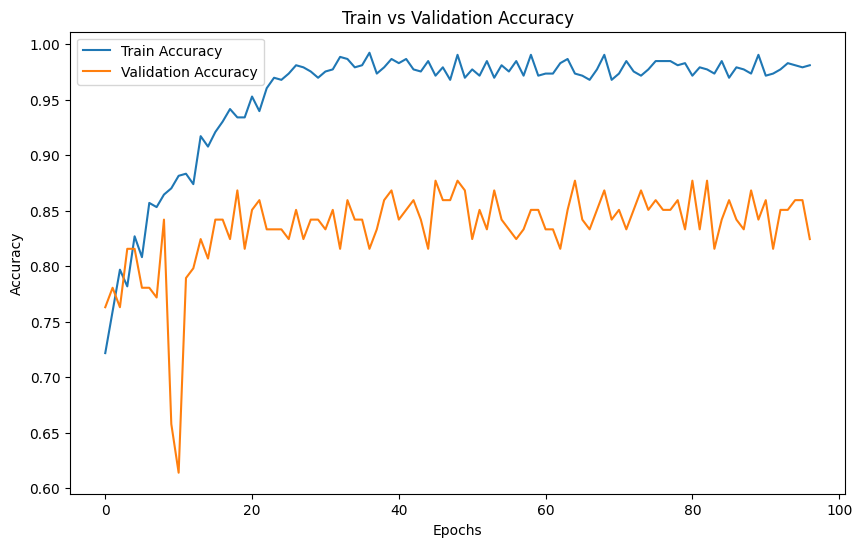

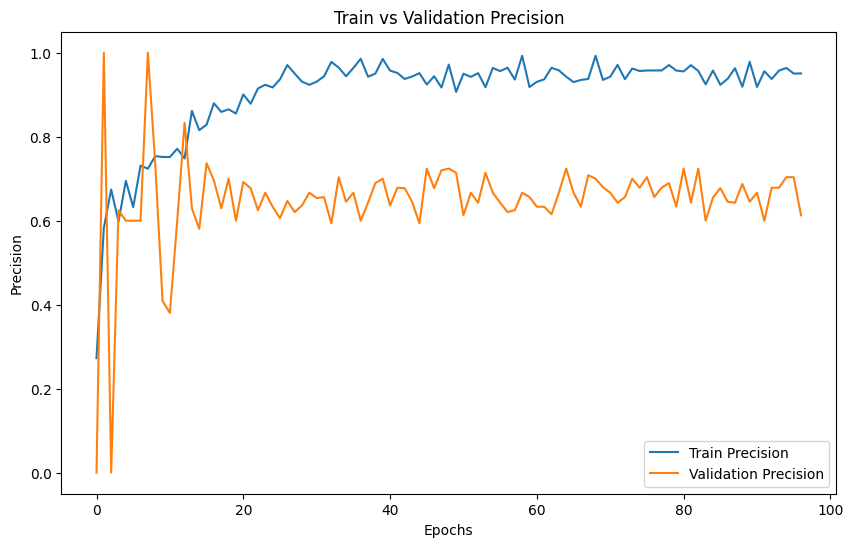

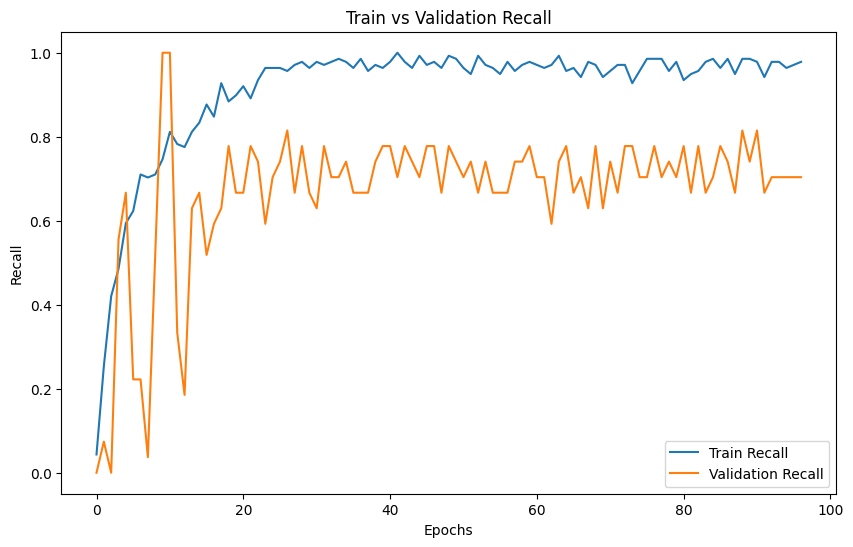

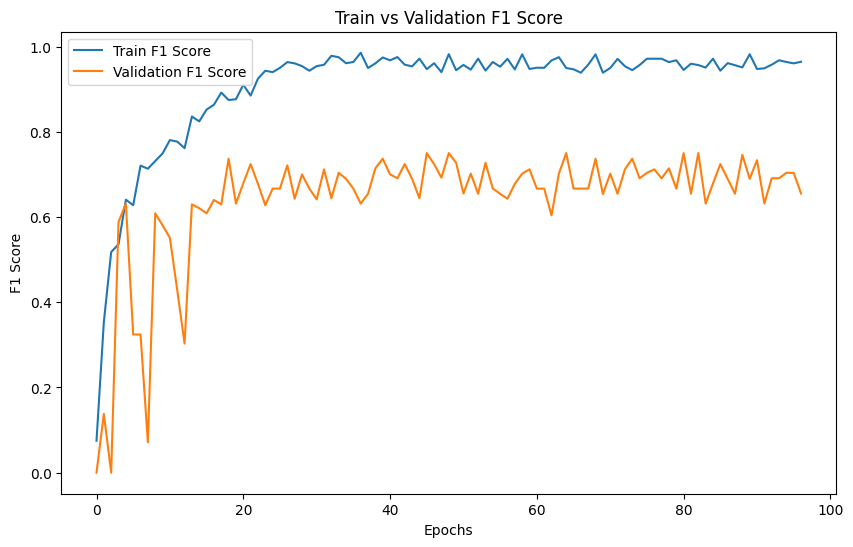

In [28]:
import matplotlib.pyplot as plt

# Function to plot metrics
def plot_metrics(train_metrics, val_metrics, metric_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train_metrics, label=f'Train {metric_name}')
    plt.plot(val_metrics, label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'Train vs Validation {metric_name}')
    plt.legend()
    plt.show()

# Plot accuracy, precision, recall, and F1 score
plot_metrics(train_acc, val_acc, 'Accuracy')
plot_metrics(train_prec, val_prec, 'Precision')
plot_metrics(train_recall, val_recall, 'Recall')
plot_metrics(train_f1, val_f1, 'F1 Score')
